In [1]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#                  FINDINGS                     #

# annualised by making returns * 252 at the beginning of script seems to work well for returns but it makes the std dev calculation completely out of wack
# annualising by making returns *np.sqrt(252) at the beginning of script works well for the final standard dev numbers
# however the return numbers are off. theres no way annual return is 2% on these etfs from the post march 2020 time period
# so clearly we need to use *252 on returns and *np.sqrt(252) on std dev in "isolation" but this is difficult but certainly not impossible
# we COULD do this post loop calculation 
# or we can try to find the correct place to implement it in the loop calculation because im sure theres somewhere 
# To help we can look at other examples and see wher they annualised their returns / stddev


# examples:
# https://towardsdatascience.com/efficient-frontier-optimize-portfolio-with-scipy-57456428323e
# codeacademy solution
# axs solution
# 

In [3]:
start = datetime.datetime(2020,3,20)
end = datetime.datetime(2022,3,7)

In [4]:
XLY = web.DataReader('XLY', 'yahoo', start, end)
XLI = web.DataReader('XLI', 'yahoo', start, end)
XLE = web.DataReader('XLE', 'yahoo', start, end)
XLK = web.DataReader('XLK', 'yahoo', start, end)
XLF = web.DataReader('XLF', 'yahoo', start, end)
XLV = web.DataReader('XLV', 'yahoo', start, end)
XLU = web.DataReader('XLU', 'yahoo', start, end)
XLB = web.DataReader('XLB', 'yahoo', start, end)

In [5]:
# getting close price data

stocks = pd.concat([XLY['Close'], XLI['Close'], XLE['Close'], XLK['Close'], XLF['Close'], XLV['Close'], XLU['Close'], XLB['Close']], axis=1)
stocks.columns = ['XLY', 'XLI', 'XLE', 'XLK', 'XLF', 'XLV', 'XLU', 'XLB']
symbols = stocks.columns
stocks

,XLY,XLI,XLE,XLK,XLF,XLV,XLU,XLB
Date,,,,,,,,
2020-03-20,87.809998,51.400002,25.860001,71.419998,18.910000,79.089996,47.820000,40.680000
2020-03-23,87.529999,48.770000,23.570000,70.400002,17.660000,74.620003,44.930000,38.349998
2020-03-24,95.739998,54.939999,27.350000,77.610001,19.850000,80.370003,49.759998,42.860001
2020-03-25,97.419998,57.830002,28.639999,77.510002,20.389999,81.440002,51.029999,43.860001
2020-03-26,101.449997,61.480000,30.389999,82.309998,21.670000,86.849998,55.380001,45.919998
...,...,...,...,...,...,...,...,...
2022-03-01,174.740005,98.400002,71.290001,150.990005,37.099998,129.240005,67.339996,81.459999
2022-03-02,178.410004,100.500000,72.919998,154.259995,38.060001,131.190002,68.160004,83.250000
2022-03-03,174.369995,100.610001,73.120003,152.419998,37.939999,131.860001,69.360001,83.349998


In [6]:
# calculating returns data from the close price data 

returns =  (stocks - stocks.shift(1)) /stocks.shift(1)
print(returns)

# and then calcualting log returns because to promote comparability between stocks with low prices and high prices.
# NOTE THERE IS SOMETHING WRONG WITH LOG RETURNS RIGHT NOW I WILL NEED TO FIX LATER - ITS SHOWING MANY NaN values
# I WILL COMMENT OUT logReturns for now and make it equal to normal returns
logReturns = returns
# logReturns = np.log(returns)
print(logReturns)

                 XLY       XLI       XLE       XLK       XLF       XLV  \
Date                                                                     
2020-03-20       NaN       NaN       NaN       NaN       NaN       NaN   
2020-03-23 -0.003189 -0.051167 -0.088554 -0.014282 -0.066103 -0.056518   
2020-03-24  0.093796  0.126512  0.160373  0.102415  0.124009  0.077057   
2020-03-25  0.017548  0.052603  0.047166 -0.001288  0.027204  0.013313   
2020-03-26  0.041367  0.063116  0.061103  0.061927  0.062776  0.066429   
...              ...       ...       ...       ...       ...       ...   
2022-03-01 -0.015161 -0.014916  0.010059 -0.019991 -0.036864 -0.005540   
2022-03-02  0.021003  0.021341  0.022864  0.021657  0.025876  0.015088   
2022-03-03 -0.022645  0.001095  0.002743 -0.011928 -0.003153  0.005107   
2022-03-04 -0.015886 -0.002187  0.028857 -0.017517 -0.018714  0.005005   
2022-03-07 -0.049009 -0.026796  0.014755 -0.036594 -0.036530 -0.017431   

                 XLU       XLB  
Date

In [7]:
# sharpe ratio
# we are interested in solving for the weights

In [8]:
# return vs volatility chart
no_of_portfolios = 10000
no_of_stocks = 8
weight = np.zeros((no_of_portfolios,no_of_stocks)) # we need to initialise the weight array used later
mean_log_returns = (logReturns.mean()+1)**(250)-1
std_dev_returns = logReturns.cov()
expectedReturn = np.zeros(no_of_portfolios)
expectedVolatality = np.zeros(no_of_portfolios)
sharpRatio = np.zeros(no_of_portfolios)



for k in range(no_of_portfolios):
    # generate random weight vector
    w = np.array(np.random.random(no_of_stocks))
    w = w / np.sum(w) # we need to normalise so the sum of the weights = 1
    weight[k,:] = w
    # expected log return
    expectedReturn[k] = np.sum(mean_log_returns * w)
    # expected volatility
    expectedVolatality[k] = np.sqrt( np.dot(w.T, np.dot(std_dev_returns, w)) )*np.sqrt(250)
    # sharpe ratio
    sharpRatio[k] = expectedReturn[k]/ expectedVolatality[k]


In [9]:
# now we want to figure out the max sharpe ratio

In [10]:
maxIndex = sharpRatio.argmax()
print(weight[maxIndex, :]) # this produces a vector that maxes for sharpe ratio aka we want .31 in stock1 0.42 in stock2 etc


[0.04814571 0.07708553 0.3031952  0.29178984 0.02956485 0.17384963
 0.04523743 0.0311318 ]


In [11]:
# now lets plot the returns vs volatility chart

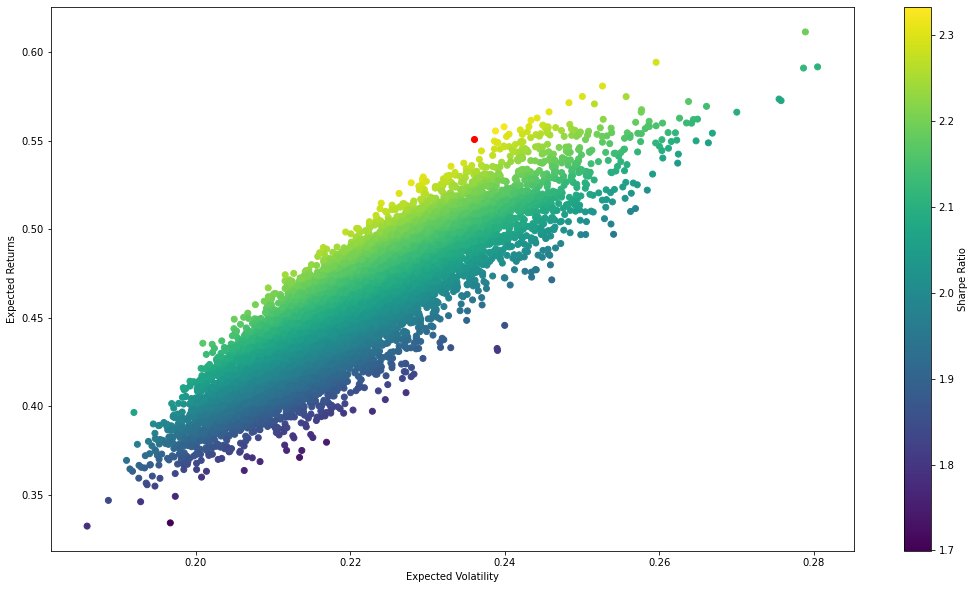

In [12]:
plt.figure(figsize=(18,10))
plt.scatter(expectedVolatality, expectedReturn, c=sharpRatio) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.colorbar(label = 'Sharpe Ratio') # legend for the color map
plt.scatter(expectedVolatality[maxIndex], expectedReturn[maxIndex], c ='red') # plotting the max sharpe ratio point
plt.show()

In [13]:
# efficient Markowitz Frontier
# we are finding a value of w which minimises volatility for the maximum possible given return
# another way of thinking about this is finding the weights of the  portfolio with the highest sharpe ratio for each volatility
# we can do this with the minimize funciton from scipy. we are going to minimize the negative Sharpe Ratio, w0 is our initial guess
# keep in mind that minimize returns a w (weights) vector. check each solution to see if it sums to 1 or not
# we are subject to box constraints on w

In [14]:


def negativeSR(w):
    w = np.array(w)  # this gives w in a format we can work with
    R = np.sum(mean_log_returns * w) # sum of our mean log returns multiplied by our weights
    V = np.sqrt( np.dot(w.T, np.dot(std_dev_returns, w)) )
    SR = R/V
    return -1 * SR

def checkSumToOne(w):
    return np.sum(w)-1 #if its 1 as it should be it returns 0

w0 = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125] #this is an intial guess
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1))
constraints = ({'type': 'eq', 'fun':checkSumToOne}) #define a type and a function

w_opt = minimize(negativeSR, w0, method='SLSQP', bounds= bounds, constraints = constraints)
w_opt

     fun: -38.18466265842024
     jac: array([ 1.02446079e+00,  4.05447197e+00,  5.72204590e-06, -1.90734863e-06,
        6.91612959e+00, -3.43322754e-05,  2.86284065e+00,  1.83684206e+00])
 message: 'Optimization terminated successfully'
    nfev: 74
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.00000000e+00, 1.22325246e-14, 4.48792429e-01, 4.93602734e-01,
       5.35130708e-14, 5.76048363e-02, 0.00000000e+00, 0.00000000e+00])

In [15]:
# the above is the solution 
# it took 10 iterations to find the solution
# the optimal portfolio is pretty close to our max sharpe ratio method
w_opt.x

array([0.00000000e+00, 1.22325246e-14, 4.48792429e-01, 4.93602734e-01,
       5.35130708e-14, 5.76048363e-02, 0.00000000e+00, 0.00000000e+00])

In [16]:
print(weight[maxIndex, :])
print(type(w_opt.x))
print('optimal portfolio weights')
print(np.round(w_opt.x, 2))
print(np.round(weight[maxIndex, :], 2))

[0.04814571 0.07708553 0.3031952  0.29178984 0.02956485 0.17384963
 0.04523743 0.0311318 ]
<class 'numpy.ndarray'>
optimal portfolio weights
[0.   0.   0.45 0.49 0.   0.06 0.   0.  ]
[0.05 0.08 0.3  0.29 0.03 0.17 0.05 0.03]


In [17]:
# plotting the efficient frontier
# calculating the lowest volatility for each return

In [18]:
returns = np.linspace(0.25,0.9,50) # the returns we are calculating between and also how many points on the frontier we want
volatility_opt = []

def minimizeMyVolatility(w):
    w = np.array(w) 
    V = np.sqrt( np.dot(w.T, np.dot(std_dev_returns, w)) )
    return V

def getReturn(w):
    w = np.array(w) 
    R = np.sum(mean_log_returns * w)
    return R

for R in returns:
    # find best volatility
    constraints = ({'type': 'eq', 'fun':checkSumToOne},
                  {'type': 'eq', 'fun': lambda w: getReturn(w) - R}) #define a type and a function
    opt = minimize(minimizeMyVolatility, w0, method='SLSQP', bounds= bounds, constraints = constraints) # the constraints will be a bit different this time because we are minimising volatility we need a constraint on returns
    # save my optimal volatility
    volatility_opt.append(opt['fun']) # stack all those optimal volaility values in volatility opt array

In [19]:
# annualising volatility_opt
print(type(volatility_opt))
print(volatility_opt)
annualised_volatility_opt = [i*np.sqrt(250) for i in volatility_opt ]
print(annualised_volatility_opt)

<class 'list'>
[0.014627118995677816, 0.014350756351238114, 0.012767244315872237, 0.011780297457164982, 0.011457363306119003, 0.011355273836723892, 0.011396600878201636, 0.011457305057057927, 0.011541878371265286, 0.011662878315061244, 0.011811293560713622, 0.011959393937733714, 0.012121210457304299, 0.012297250999388809, 0.012486580021051538, 0.01268760239305466, 0.01290099046545573, 0.013125862569380507, 0.013361843036072128, 0.013614753918883034, 0.013874798941979398, 0.014147766423673203, 0.014429713799516238, 0.014756220233150917, 0.015017544275082829, 0.015366196093450194, 0.015686143285047475, 0.016014916612944807, 0.016288582560912878, 0.01670026705721711, 0.016972674649844834, 0.017319966676111603, 0.017679514901274618, 0.018066395376695455, 0.018482269508382006, 0.018925226041115944, 0.01939340933682646, 0.01988503759456451, 0.020398415737906784, 0.02093283329649524, 0.02148411980502488, 0.02205354389471833, 0.022638914347861253, 0.023239026174027805, 0.023852766759845035, 0.

In [20]:
# plotting the graph again

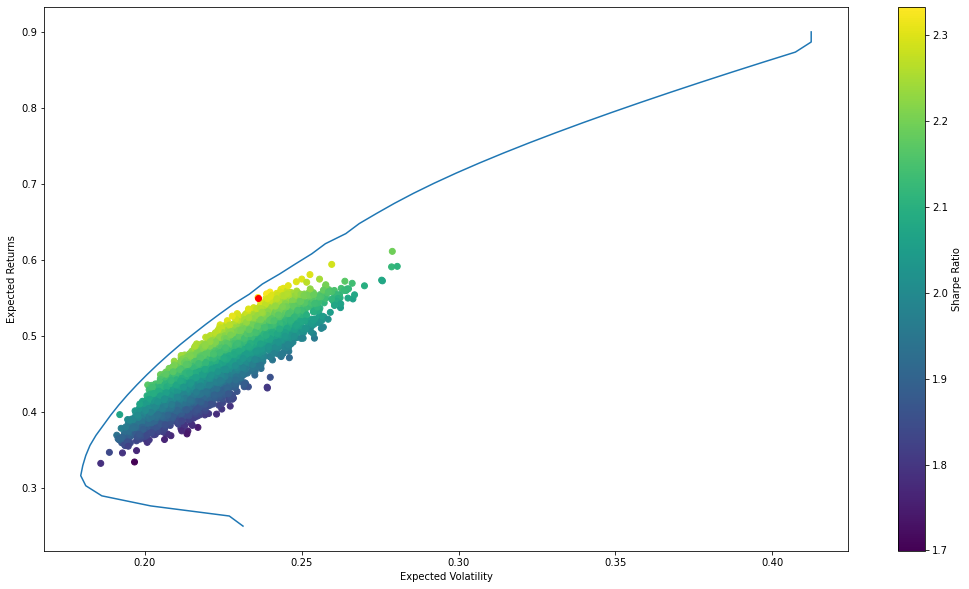

In [21]:
plt.figure(figsize=(18,10))
plt.scatter(expectedVolatality, expectedReturn, c=sharpRatio) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.colorbar(label = 'Sharpe Ratio') # legend for the color map
plt.scatter(expectedVolatality[maxIndex], expectedReturn[maxIndex], c ='red') # plotting the max sharpe ratio point
plt.plot(annualised_volatility_opt, returns)
plt.show()

In [22]:
# plotting the ETF's on the chart


In [23]:
mean_log_returns
type(mean_log_returns)

pandas.core.series.Series

In [24]:
new_std_returns = logReturns.std()*np.sqrt(250)

In [25]:
test = pd.concat([new_std_returns, mean_log_returns], axis= 1)
print(test)
x_values = test[0].values.tolist()
y_values =  test[1].values.tolist()


            0         1
XLY  0.233832  0.406008
XLI  0.247115  0.426305
XLE  0.412423  0.879897
XLK  0.259519  0.475786
XLF  0.283712  0.438737
XLV  0.184968  0.308992
XLU  0.231275  0.261287
XLB  0.249733  0.453882


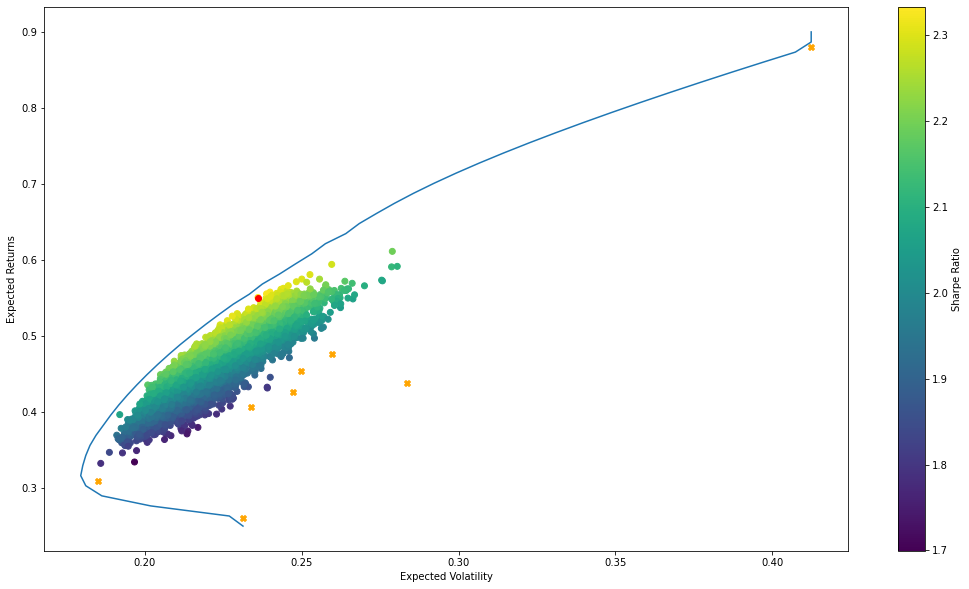

In [26]:
plt.figure(figsize=(18,10))
plt.scatter(expectedVolatality, expectedReturn, c=sharpRatio) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.colorbar(label = 'Sharpe Ratio') # legend for the color map
plt.scatter(expectedVolatality[maxIndex], expectedReturn[maxIndex], c ='red') # plotting the max sharpe ratio point
plt.scatter(x_values, y_values, marker = 'X', color = 'orange')
plt.plot(annualised_volatility_opt, returns)
plt.show()

<class 'pandas.core.indexes.base.Index'>


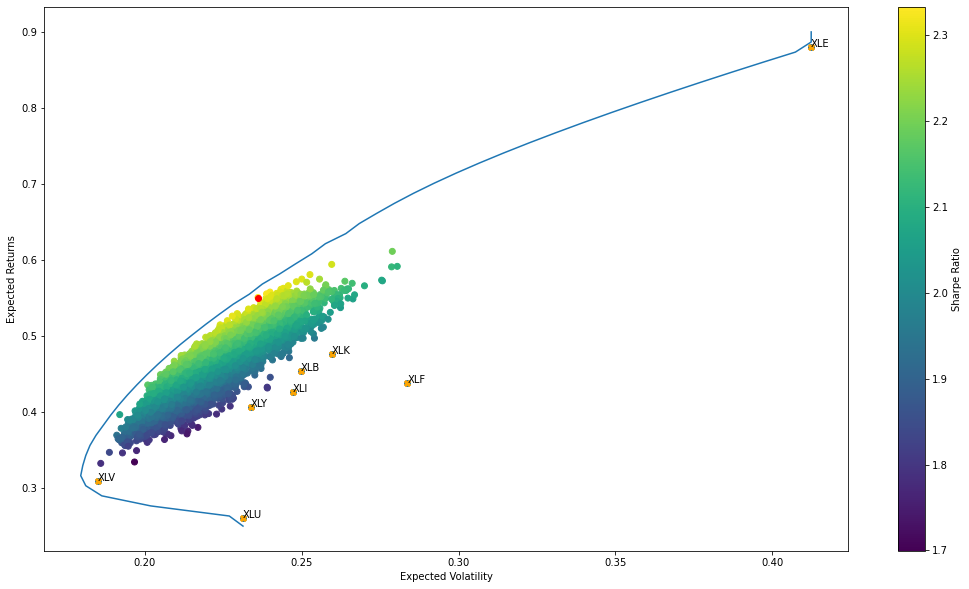

('XLY - Consumer Discretionary', 'XLI - Industrial', 'XLE - Energy', 'XLK - Technology', 'XLF - Financial', 'XLV - Health Care', 'XLU - Utilities', 'XLB - Materials')


In [27]:
print(type(symbols))
symbol_expansions = ("XLY - Consumer Discretionary", "XLI - Industrial", "XLE - Energy", "XLK - Technology", "XLF - Financial", "XLV - Health Care","XLU - Utilities", "XLB - Materials")


fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(x_values, y_values)


for i, symb in enumerate (symbols):
    ax.annotate(symbols[i], (x_values[i], y_values[i]))
plt.scatter(expectedVolatality, expectedReturn, c=sharpRatio) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.colorbar(label = 'Sharpe Ratio') # legend for the color map
plt.scatter(expectedVolatality[maxIndex], expectedReturn[maxIndex], c ='red') # plotting the max sharpe ratio point
plt.scatter(x_values, y_values, marker = 'X', color = 'orange')
plt.plot(annualised_volatility_opt, returns)
plt.show()
plt.show()
print(symbol_expansions)

In [28]:
#            markowitz portfolio solver                #

In [50]:
pBar = (logReturns.mean()+1)**(250)-1
Sigma = (logReturns.cov()+1)**(250)-1
rMin = 0.4




In [51]:
print(pBar)
print(Sigma)

XLY    0.406008
XLI    0.426305
XLE    0.879897
XLK    0.475786
XLF    0.438737
XLV    0.308992
XLU    0.261287
XLB    0.453882
dtype: float64
          XLY       XLI       XLE       XLK       XLF       XLV       XLU  \
XLY  0.056193  0.043249  0.046231  0.052260  0.044971  0.027727  0.028502   
XLI  0.043249  0.062961  0.077887  0.040318  0.064668  0.031519  0.038483   
XLE  0.046231  0.077887  0.185347  0.040021  0.094202  0.035060  0.041613   
XLK  0.052260  0.040318  0.040021  0.069660  0.040241  0.034764  0.029698   
XLF  0.044971  0.064668  0.094202  0.040241  0.083807  0.032604  0.040355   
XLV  0.027727  0.031519  0.035060  0.034764  0.032604  0.034803  0.029138   
XLU  0.028502  0.038483  0.041613  0.029698  0.040355  0.029138  0.054938   
XLB  0.042540  0.056899  0.073891  0.041404  0.061716  0.032214  0.037430   

          XLB  
XLY  0.042540  
XLI  0.056899  
XLE  0.073891  
XLK  0.041404  
XLF  0.061716  
XLV  0.032214  
XLU  0.037430  
XLB  0.064344  


In [52]:
def ourMarkowitzSingleEquationSolver(rMin, Sigma, pBar):
    N = len(Sigma)
    o = np.ones(N)
    SigmaInv = np.linalg.inv(Sigma)
    a = np.dot(pBar.T, np.dot(SigmaInv, pBar))
    b = np.dot(pBar.T, np.dot(SigmaInv, o))
    c = np.dot(o.T, np.dot(SigmaInv, o))
    return (1/ (a*c - b**2)) * np.dot(SigmaInv, ((c * rMin - b)* pBar +(a - b * rMin)*o))

In [53]:
weights_2_pct_return = ourMarkowitzSingleEquationSolver(rMin, Sigma, pBar)
weights_2_pct_return

array([ 0.34158393, -0.05667743,  0.16483039, -0.0597576 , -0.20897406,
        0.66116029,  0.07981936,  0.07801512])

In [54]:
np.sum(weights_2_pct_return)

1.0

In [55]:
#                               scipy method                         #

In [106]:
pBar = (logReturns.mean()+1)**(250)-1
Sigma = (logReturns.cov()+1)**(250)-1
Sigma_Un_Annual = logReturns.cov()
rMin = 0.5

def riskFunction(w):
    return np.dot(w.T,np.dot(Sigma_Un_Annual, w))

w0 = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

def checkMinimumReturn(w):
    RHS = rMin - np.sum(pBar * w)
    return RHS
def checkSumToOne(w):
    return np.sum(w) - 1

constraints = ({'type':'eq', 'fun':checkMinimumReturn},{'type':'eq', 'fun':checkSumToOne})

w_opt = minimize(riskFunction, w0, method='SLSQP', bounds=bounds, constraints=constraints)

In [107]:
w_scipy = w_opt.x

print(w_scipy)

weights_in_pct = ["%.2f"%(i * 100) for i in w_scipy]
print(weights_in_pct)

[0.11599043 0.11957019 0.200981   0.12853288 0.1217624  0.09862412
 0.09000428 0.12453471]
['11.60', '11.96', '20.10', '12.85', '12.18', '9.86', '9.00', '12.45']


In [108]:
risk_scipy = (riskFunction(w_scipy))*np.sqrt(250)
risk_no_annual = riskFunction(w_scipy)
edited = (risk_scipy*100) /2
print(edited)
print( risk_no_annual*1000)

0.16856822172345107
0.21322380870815177
